
![D.lensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example - full sky
In this notebook you perfrom QE and iterative lensing reconstruction for a single simulation, and for the full sky.
The simulations are created upon runtime inclusive of isotropic white noise and without foregrounds, using a built-in CMB-simulations module.
At the end of this tutorial, you will plot the lensing potential estimates and obtain delensed power spectra to calculate the residual lensing amplitude.

The configuration file is [here](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_fullsky_fastWF.py), and you can freely change the parameters to your liking. In this configuration file, there are a few objects:

 * `DLENSALOT_Analysis` collects all configurations for the analysis of the data/simulations
 * `DLENSALOT_Data` configures the data which is used. In this minimal working example, we generate the simulation data on the fly and therefore need to choose the simulation module and a few parameters for this
 * `DLENSALOT_Noisemodel` configures the noise model with which the Wiener-filtering is done. 
 * `DLENSALOT_Qerec` and `DLENSALOT_Itrec` are lensing reconstruction specific settings.


Notes
 * rhits_normalized should be more a path to inverse pixel noise map

In [2]:
from IPython.display import clear_output
from datetime import datetime

import os
from os.path import join as opj

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import lenscarf
from lenscarf.run import run
from lenscarf.lerepi.visalot import plot_helper as ph

fn = opj(os.getcwd(), 'conf_mwe_fullsky_fastWF.py')

if "SCRATCH" not in os.environ:
    os.environ["SCRATCH"] = "/mnt/c/Users/sebas/OneDrive/SCRATCH"

cond4mpi does not exists
could not setup healpix hack. reverting to standard healpy


# QE lensing reconstruction
The following cell,
 
 * line 1: initialises D.lensalot for a QE lensing reconstruction job (`job_id`) and the [configuration file](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_fullsky.py) ,
 * line 2: perfroms lensing reconstruction and calculates both, the lensing potential, and the B-lensing template.


When run for the first time, `.run()` generates CMB simulations and stores them as defined in the `DLENSALOT_data.class_parameters.lib_dir` parameter (check out the configuration file). If this path is not convenient, please choose one that works for you.

In [2]:
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=True).job
ana_mwe.run()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 15:42:41


# iterative lensing reconstruction

The following cell repeats above, but for the iterative case. The number of iterations is defined in `DLENSALOT_Itrec.itmax`.
For the iterative Wiener-filtering we use approximate solutions, allowing us to get fast results in this tutorial's idealized setting.

In [3]:
ana_mwe = run(config=fn, job_id='MAP_lensrec', verbose=True).job
# ana_mwe.run()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 19:50:52


# Check your results
## lensing potential
After completion of above cells, you may want to see the reconstructed lensing potential.
`get_plm_it(idx, its)` returns the spherical harmonics for simulation `idx` and iterations `its`.

INFO:: 02-23 19:50:: lenscarf.core.handler.log - get_plm_it(simidx=0, its=[0]) started
INFO:: 02-23 19:50:: lenscarf.core.handler.log - get_plm_it(simidx=0, its=[0]) finished
INFO:: 02-23 19:50:: lenscarf.core.handler.log - get_plm_it(simidx=0, its=[10]) started
INFO:: 02-23 19:51:: lenscarf.core.handler.log - get_plm_it(simidx=0, its=[10]) finished


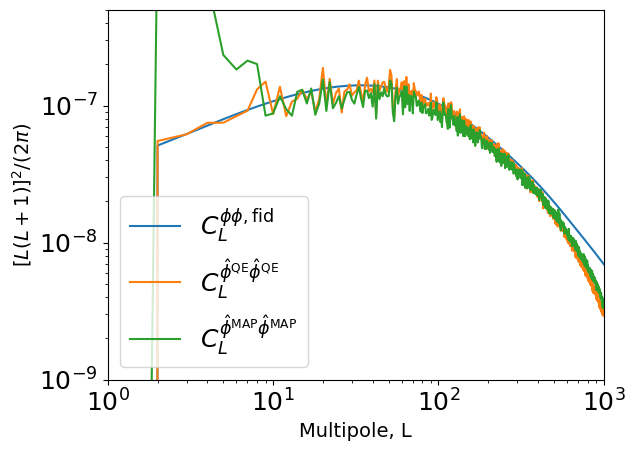

In [4]:
plm_QE = ana_mwe.get_plm_it(0, [0])[0]
plm_MAP = ana_mwe.get_plm_it(0, [10])[0]

ll = np.arange(0,ana_mwe.qe_lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)

plt.plot(scale_factor*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$')
plt.plot(scale_factor*hp.alm2cl(plm_QE), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')
plt.plot(scale_factor*hp.alm2cl(plm_MAP), label=r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$')
plt.legend(fontsize=18, loc='lower left')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-9,5e-7)
plt.yscale('log')

The blue line is the fiducial lensing potential. The QE and MAP estimates are shown in orange and green, and they agree well with the input. The drop at higher multipoles is due to the filtering. You will check the cross correlation to the input a bit below in this tutorial.

You can also compare them on map-level. We bandpass the multipoles to make the similarities more apparent

In [ ]:
hp.mollview(hp.alm2map(ph.bandpass_alms(hp.almxfl(plm_QE,np.sqrt(ll*(ll+1))),10,1000), nside=512), title='reconstructed lensing deflection, QE', cmap='YlGnBu')
hp.mollview(hp.alm2map(ph.bandpass_alms(hp.almxfl(plm_MAP,np.sqrt(ll*(ll+1))),10,1000), nside=512), title='reconstructed lensing deflection, MAP', cmap='YlGnBu')

In [ ]:
hp.mollview(hp.alm2map(ph.bandpass_alms(hp.almxfl(input_blensing,np.sqrt(ll*(ll+1))),2,1000), nside=512), title='fiducial lensing deflection', cmap='YlGnBu')
hp.mollview(hp.alm2map(ph.bandpass_alms(hp.almxfl(input_blensing-blens_residual_QE,np.sqrt(ll*(ll+1))),2,1000), nside=512), title='QE delensed', cmap='YlGnBu')
hp.mollview(hp.alm2map(ph.bandpass_alms(hp.almxfl(input_blensing-blens_residual_MAP,np.sqrt(ll*(ll+1))),2,1000), nside=512), title='MAP delensed', cmap='YlGnBu')

In [ ]:
hp.mollview(hp.alm2map(ph.bandpass_alms(hp.almxfl(blt_QE,np.sqrt(ll*(ll+1))),2,1000), nside=512), title='BLT QE', cmap='YlGnBu')
hp.mollview(hp.alm2map(ph.bandpass_alms(hp.almxfl(blt_MAP,np.sqrt(ll*(ll+1))),2,1000), nside=512), title='BLT MAP', cmap='YlGnBu')

In [ ]:
blens_map = hp.alm2map(ph.bandpass_alms(input_blensing,0,200), nside=1024)
blt_QE_map = hp.alm2map(ph.bandpass_alms(blt_QE,0,200), nside=1024)
blt_MAP_map = hp.alm2map(ph.bandpass_alms(blt_MAP,0,200), nside=1024)

# Delensed spectrum
For both QE and iterative lensing reconstruction, D.lensalot already calculated the B-lensing templates. You can use them to delens the B-lensing maps and obtain residual maps

In [5]:
from lenscarf.utils_hp import alm_copy, almxfl
input_blensing =  alm_copy(ana_mwe._sims.get_sim_blm(0), ana_mwe.class_parameters['lmax'], 1024, 1024)
blt_QE = ana_mwe.get_blt_it(0, 0)
blt_MAP = ana_mwe.get_blt_it(0, ana_mwe.itmax)

INFO:: 02-23 19:52:: lenscarf.core.handler.log - get_blt_it(simidx=0, it=0) started
INFO:: 02-23 19:52:: lenscarf.core.handler.log - get_wflm(simidx=0) started
INFO:: 02-23 19:52:: lenscarf.core.handler.log - get_wflm(simidx=0) finished
INFO:: 02-23 19:52:: lenscarf.core.handler.log - get_plm(simidx=0, sub_mf=False) started
INFO:: 02-23 19:52:: lenscarf.core.handler.log - get_plm(simidx=0, sub_mf=False) finished
INFO:: 02-23 19:52:: lenscarf.remapping.__init__ -  Deflection std 0.00e+00 amin
INFO:: 02-23 19:52:: lenscarf.iterators.iteration_handler.log - get_datmaps() started
INFO:: 02-23 19:53:: lenscarf.iterators.iteration_handler.log - get_datmaps() finished
INFO:: 02-23 19:53:: lenscarf.iterators.iteration_handler.log - get_filter() started
INFO:: 02-23 19:53:: lenscarf.iterators.iteration_handler.log - get_filter() finished
INFO:: 02-23 19:53:: lenscarf.iterators.iteration_handler.log - get_iterator() started
INFO:: 02-23 19:53:: lenscarf.iterators.iteration_handler.log - get_iter

In [6]:
blens_residual_QE = input_blensing - blt_QE
blens_residual_MAP = input_blensing - blt_MAP

Text(0, 0.5, '$C_\\ell [\\mu $$\\rm{K}^2$]')

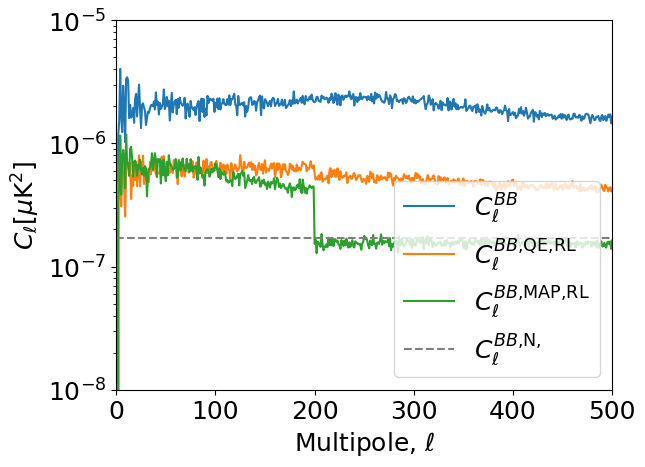

In [7]:
plt.plot(hp.alm2cl(input_blensing, lmax_out=1000), label=r'$C_\ell^{BB}$')
plt.plot(hp.alm2cl(blens_residual_QE, lmax_out=1000), label=r'$C_\ell^{BB{,}{\rm QE{,}RL}}$')
plt.plot(hp.alm2cl(blens_residual_MAP, lmax_out=1000), label=r'$C_\ell^{BB{,}{\rm MAP{,}RL}}$')

plt.hlines((ana_mwe.nlev_p/180/60*np.pi)**2,0,500, color='grey', ls='--', label=r'$C_\ell^{BB{,}{\rm N{,}}}$')


plt.legend(loc='lower right')
plt.yscale('log')
plt.xlim(0,500)
plt.ylim(1e-8,1e-5)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('$C_\ell [\mu $'+r'$\rm{K}^2$]')

## Cross-corr coefficient

In [ ]:
itmax_loc = 10

In [ ]:
from lenscarf.iterators.statics import rec as rec
print(rec.maxiterdone(ana_mwe.libdir_iterators(ana_mwe.k, 0, ana_mwe.version)))

In [ ]:

ana_mwe_const = run(config=fn, job_id='MAP_lensrec', verbose=False).job
plm_in_const = alm_copy(ana_mwe_const._sims.get_sim_plm(0), 5025, ana_mwe_const.it_lm_max_qlm[0], ana_mwe_const.it_lm_max_qlm[1])
plm_MAP_const = ana_mwe_const.get_plm_it(0, np.arange(itmax_loc))
deleff_MAP_const = hp.alm2cl(plm_in_const, plm_MAP_const[-1], lmax_out=ana_mwe_const.it_lm_max_qlm[0])**2/(hp.alm2cl(plm_MAP_const[-1], lmax_out=ana_mwe_const.it_lm_max_qlm[0])*hp.alm2cl(plm_in_const, lmax_out=ana_mwe_const.it_lm_max_qlm[0]))

In [ ]:
ll = np.arange(0,ana_mwe.qe_lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)
from lenscarf.utils_hp import alm_copy, almxfl

In [ ]:
plm_in = alm_copy(ana_mwe._sims.get_sim_plm(0), 5025, ana_mwe.it_lm_max_qlm[0], ana_mwe.it_lm_max_qlm[1])
plm_MAP = ana_mwe.get_plm_it(0, np.arange(itmax_loc))

In [ ]:
deleff_MAP = hp.alm2cl(plm_in, plm_MAP[-1], lmax_out=ana_mwe.it_lm_max_qlm[0])**2/(hp.alm2cl(plm_MAP[-1], lmax_out=ana_mwe.it_lm_max_qlm[0])*hp.alm2cl(plm_in, lmax_out=ana_mwe.it_lm_max_qlm[0]))

In [ ]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(111)

iterator = 'const'

p = plt.plot(deleff_MAP, alpha=0.5, label='fastWF')
# plt.plot(movavg(deleff_MAP), label=r'$\hat{\phi}^{\rm MAP}$'+ '({}, {})'.format('Gauss', 'fastWF'), color=p[0].get_color())

q = plt.plot(deleff_MAP_const, alpha=0.5, label='const')
# plt.plot(movavg(deleff_MAP_const), label=r'$\hat{\phi}^{\rm MAP}$'+ '({}, {})'.format('Gauss', 'constMF'), color=q[0].get_color())
    
plt.ylim(1e-1,1.1)
plt.xlim(0,100)
plt.yscale('log')
plt.legend(title='Full sky, iteration {}'.format(itmax_loc), loc='upper right')
plt.xlabel('Multipole, $L$')
plt.ylabel(r'$D = (C_L^{\hat{\phi}\phi^{\rm in}})^2 / \left( C_L^{\phi^{\rm in}\phi^{\rm in}} C_L^{\hat{\phi}\hat{\phi}}\right)$')
plt.title('Cross-correlation coefficient')

# plt.savefig('vid/frame{}.png'.format(itmax_loc-1), bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8,6))
fig.add_subplot(111)


p = plt.plot(deleff_MAP/deleff_MAP_const, alpha=0.5)
plt.plot(movavg(deleff_MAP/deleff_MAP_const), label=r'$\hat{\phi}^{\rm MAP}$', color=p[0].get_color())

# plt.yscale('log')
plt.legend(title='Full sky, iteration {}'.format(itmax_loc), loc='lower right')
plt.xlabel('Multipole, $L$')
plt.ylabel(r'D (fastWF) / D (const)')
plt.title('Ratio cross-correlation coefficient')

plt.xlim(0,4000)
plt.ylim(0.75,1.05)

plt.hlines(1,0,4000, color='grey', ls='--')

# plt.savefig('vid/frame{}.png'.format(itmax_loc-1), bbox_inches='tight')

## residual lensing amplitude $A_{\rm lens}$
A simple estimate of the reduction of lensing power is to take the ratio between the input and resdiual B-lensing signal, averaged across the scales of interest. Here, we simply take the scales about the recombination peak

In [ ]:
print(20*'~.')
print('nlev_p: {}, lmax_ivf: {}, beam: {}'.format(ana_mwe.nlev_p, ana_mwe.lm_max_ivf, ana_mwe._sims.beam))
print('A_{lens}^{QE}:'+'\t{:.3f}'.format(np.mean((hp.alm2cl(blens_residual_QE, lmax_out=200)/hp.alm2cl(input_blensing, lmax_out=200))[30:200])))
print('A_{lens}^{MAP}:'+'\t{:.3f}'.format(np.mean((hp.alm2cl(blens_residual_MAP, lmax_out=200)/hp.alm2cl(input_blensing, lmax_out=200))[30:200])))
print(20*'~.')

# Summary and next steps
This tutorial demonstrated the usage of D.lensalot in an idealized setting, and you obtained lensing potential estimates and residual lensing amplitudes from simulation data generated upon runtime.

D.lensalot can also perfrom lensing reconstruction on more challenging settings such as,

 * masked sky,
 * inhomogeneous noise,
 * data inclusive of foreground (residuals).
 
Further, it can calculate reconstruction noise `N0`, and `N1`, and make analytical predictions for the delensed power spectra.
It also has MPI support.
 
Please check out the other tutorials, or see the [documentation](link_to_rtd_doc), or [github](https://github.com/NextGenCMB/D.lensalot) for more.